<a href="https://colab.research.google.com/github/Vinaya1204/FMML_2023/blob/Labs/Module_01_Lab_03_Agumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Agumentation**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=50)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

In [8]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/250
test_X = test_X/250

train_X = train_X[::1500,:,:].copy()
train_y = train_y[::1500].copy()

In [9]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query
  sq = diff*diff
  dist = sq.sum(1)
  label = trainlabel[np.argmin(dist)]
  return label

def NN(traindata, trainlabel, testdata):
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum()
  return correct/len(gtlabel)

In [10]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6227


# Agumentation 1-Rotation

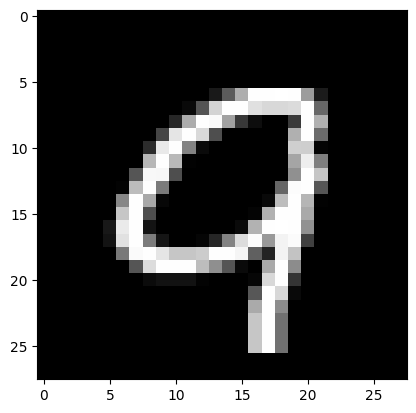

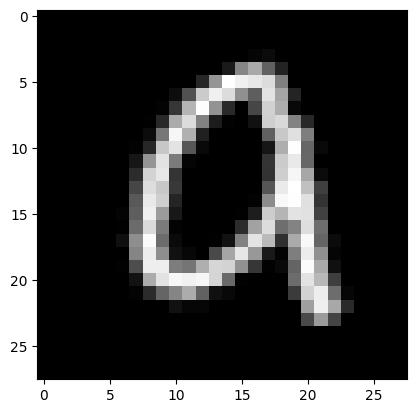

In [11]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

Presenting slightly different image every time we run this function.

In [12]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample)

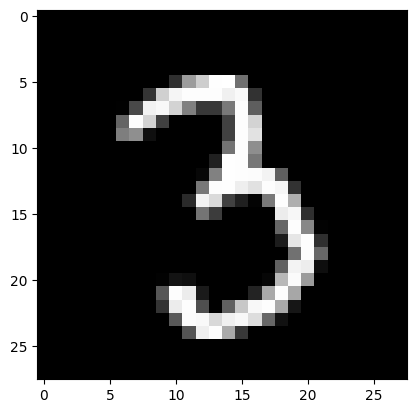

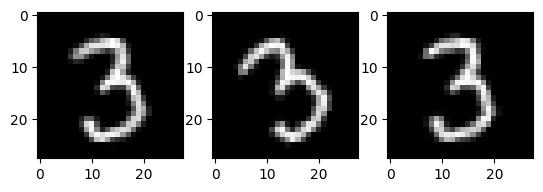

In [20]:
sample = train_X[20]
angleconstraint = 75
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')

In [21]:
angleconstraint = 75
naugmentations = 5

augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint)))
  auglabel = np.concatenate((auglabel, train_y))

testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6676


Grid search to find the best angle constraint.

In [22]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90]
accuracies = np.zeros(len(angleconstraints), dtype=np.float)

for ii in range(len(angleconstraints)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))

  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-22-d31041c8a6f1>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float)


Accuracy after rotation augmentation constrained by  0  is  0.6227
Accuracy after rotation augmentation constrained by  10  is  0.6524
Accuracy after rotation augmentation constrained by  20  is  0.6654
Accuracy after rotation augmentation constrained by  30  is  0.6752
Accuracy after rotation augmentation constrained by  40  is  0.6789
Accuracy after rotation augmentation constrained by  50  is  0.6805
Accuracy after rotation augmentation constrained by  60  is  0.6841
Accuracy after rotation augmentation constrained by  70  is  0.6755
Accuracy after rotation augmentation constrained by  80  is  0.6657
Accuracy after rotation augmentation constrained by  90  is  0.6588


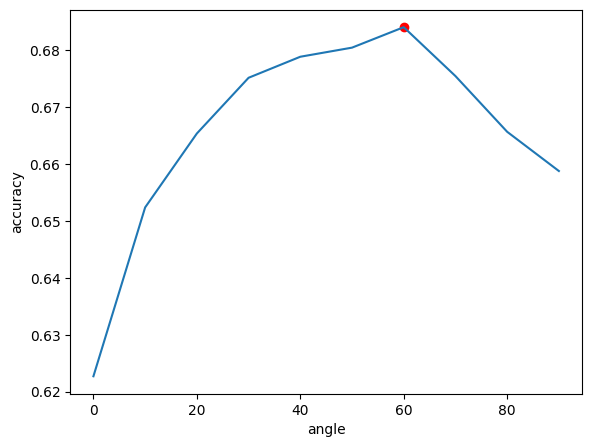

In [25]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

The best angle constraint from the grid search is 60.:

# Agumentation 2-Shear

In [26]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount)
  img = warp(sample, tform)
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

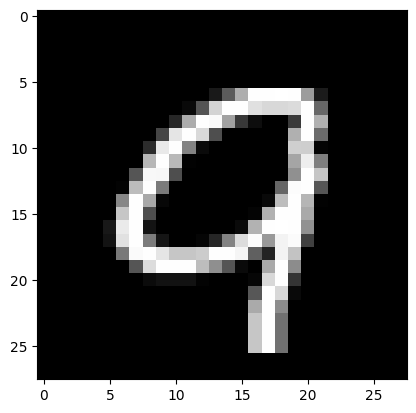

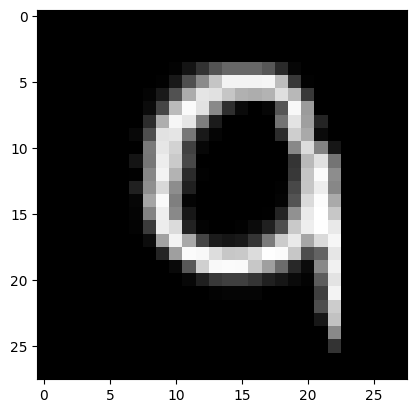

In [32]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

plt.imshow(shear(sample, 0.45), cmap='gray')

Random shear

In [33]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample)

Grid search to find the best shear constraint:

In [35]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
accuracies = np.zeros(len(shearconstraints), dtype=np.float)

for ii in range(len(shearconstraints)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))

  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-35-bf15a0098310>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float)


Accuracy after shear augmentation constrained by  0  is  0.6227
Accuracy after shear augmentation constrained by  0.2  is  0.6272
Accuracy after shear augmentation constrained by  0.4  is  0.6169
Accuracy after shear augmentation constrained by  0.6  is  0.6537
Accuracy after shear augmentation constrained by  0.8  is  0.6612
Accuracy after shear augmentation constrained by  1.0  is  0.6446
Accuracy after shear augmentation constrained by  1.2  is  0.6545
Accuracy after shear augmentation constrained by  1.4  is  0.6415
Accuracy after shear augmentation constrained by  1.6  is  0.6276
Accuracy after shear augmentation constrained by  1.8  is  0.6014
Accuracy after shear augmentation constrained by  2.0  is  0.6201


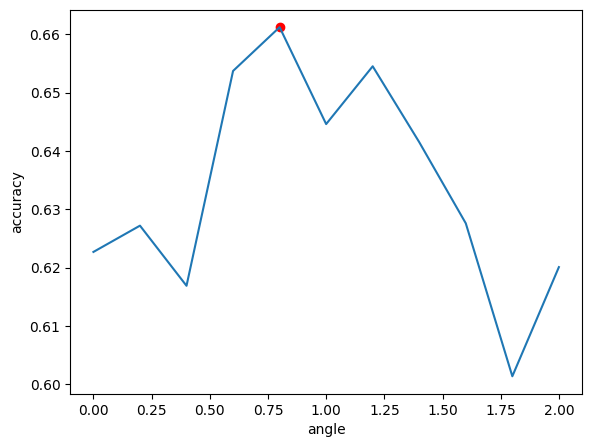

In [36]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

The best shear constraint from grid search is 0.75.

 Function to do both shear and rotation to the sample.

In [37]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii])
  return np.squeeze(nsample)

In [42]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
angleconstraints = [0,10,20,30,40,50,60,70,80,90]
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=np.float)

for ii in range(len(hyp)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1])))
    auglabel = np.concatenate((auglabel, train_y))

  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-42-5d09affdcb42>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float)


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6143
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.5837
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5796
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5991
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.5909
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.5847
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5832
Accuracy after augmentation shear: 0.0 angle: 70.0  is  0.5765
Accuracy after augmentation shear: 0.0 angle: 80.0  is  0.5979
Accuracy after augmentation shear: 0.0 angle: 90.0  is  0.5769
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6162
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5736
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.5878
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.5888
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5971
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0

 Plotting it in two dimensionally to see which is the best value for the hyperparameters:

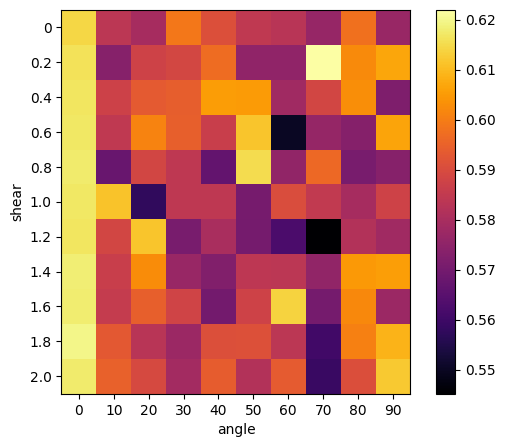

In [43]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

As we can see the best accuracy is when rotation angle is 0.

# **Questions**

1)What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

The best value for angle constraint is 60 and the best value for shear constraint is 0.75.(As for the above example).

And if we compare the acurracy-

Accuracy with angle constraint is above 0.68.

Accuracy with shear constraint is nearly 0.66.

Accuracy without agumentation is 0.6227.

We can observe that the accuracy with angle and shear constraint almost increased by 0.4,0.6 respectively compared to accuracy without agumentation.


2)Can you increase the accuracy by increasing the number of augmentations from each sample?

Increasing the number of augmentations per sample can have both positive and negative effects on model performance

It's often a good idea to experiment with different levels of data augmentation and monitor the model's performance on a validation set.



3)Try implementing a few augmentations of your own and experimenting with them.

Trying few other agumentations.

Agumentation 3:Wrap Shift

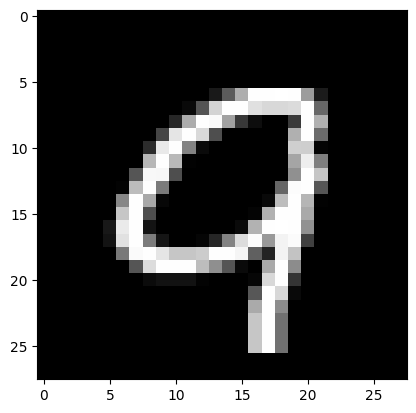

Text(0.5, 1.0, 'Wrap Shift')

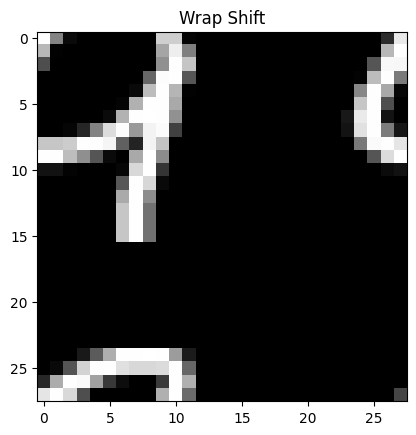

In [57]:
sample=train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

transform = AffineTransform(translation=(10,10))
wrapShift = warp(sample,transform,mode='wrap')
plt.imshow(wrapShift,cmap='gray')
plt.title('Wrap Shift')




Agumentation 4-Flipping

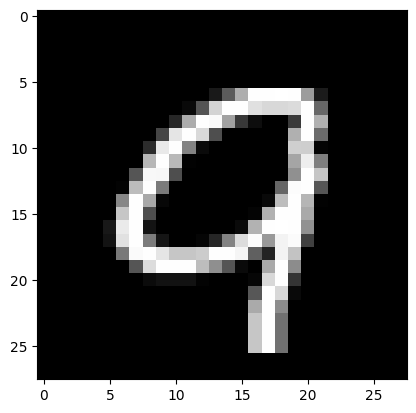

Text(0.5, 1.0, 'Left to Right Flipped')

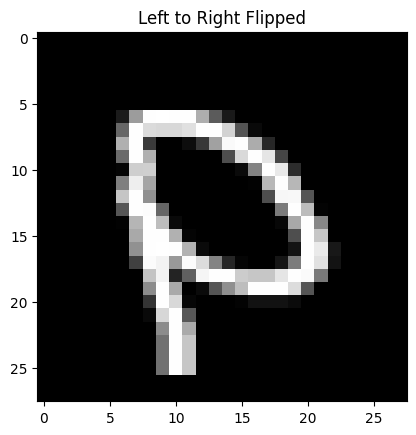

In [58]:
sample=train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

flipLR = np.fliplr(sample)

plt.imshow(flipLR,cmap='gray')
plt.title('Left to Right Flipped')

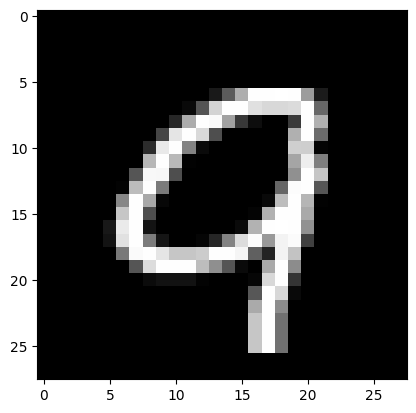

Text(0.5, 1.0, 'Up Down Flipped')

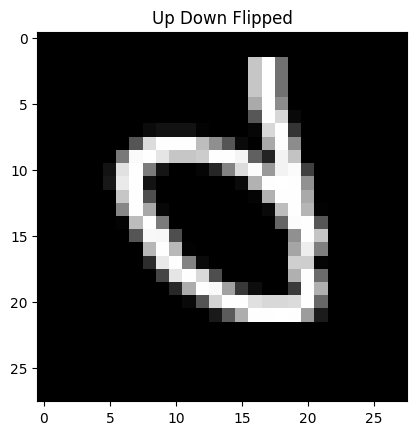

In [59]:
sample=train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

flipUD = np.flipud(sample)

plt.imshow(flipUD,cmap='gray')
plt.title('Up Down Flipped')

Agumentation 5-Blurring the image

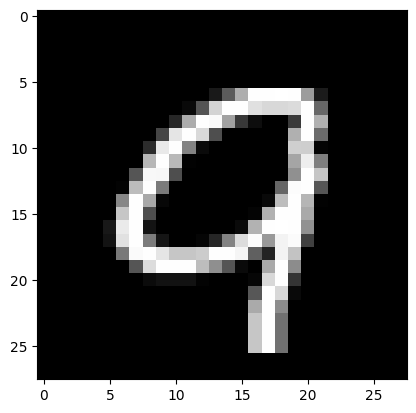

Text(0.5, 1.0, 'Blurred Image')

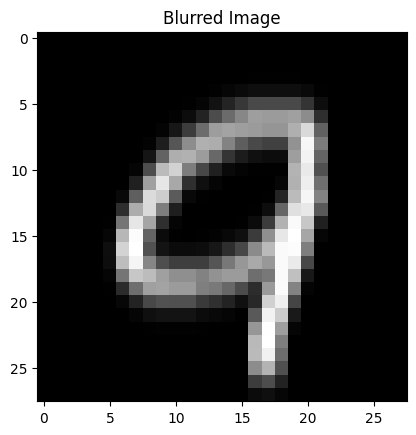

In [61]:
sample=train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()
blurred = gaussian(sample,sigma=1,multichannel=True)

plt.imshow(blurred,cmap='gray')
plt.title('Blurred Image')

4)What is the smallest training dataset you can take and still get accuracy above 50%?

The smallest training dataset size required to achieve accuracy above 50% depends on various factors, including the complexity of the task, the diversity of the data, the quality of the features, and the effectiveness of the chosen model and training strategy. There's no one-size-fits-all answer, and it's highly dependent on the specific problem at hand.